# My questions for Rob:
- Which projection do I want?
- How can I apply cartopy to my maps? / Is there another way to project my data onto a different coordinate system?
- How do I get WGS 84 (ESPG 4326) latitudes in my latitudinal transects?

## Which projection do I want?
https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html

I want a prjection that shows the Nordic Seas, SPG and STG. 

<span style="color:red">By now a simple PlateCarree projection would already be great</span>

## How can I apply cartopy to my maps? / Is there another way to project my data onto a different coordinate system?

In [3]:
import os                  

import numpy as np
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
import cartopy

ticker = matplotlib.ticker
ccrs = cartopy.crs

In [23]:
# load file
temp_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/temp_1231.001.nc'
ds_temp = xr.open_dataset(temp_file).isel(time=0)

In [26]:
field = ds_temp.TEMP.isel(z_t=0).squeeze()
extent = (ds_temp.TLONG.min(), ds_temp.TLONG.max(), ds_temp.TLAT.min(), ds_temp.TLAT.max())

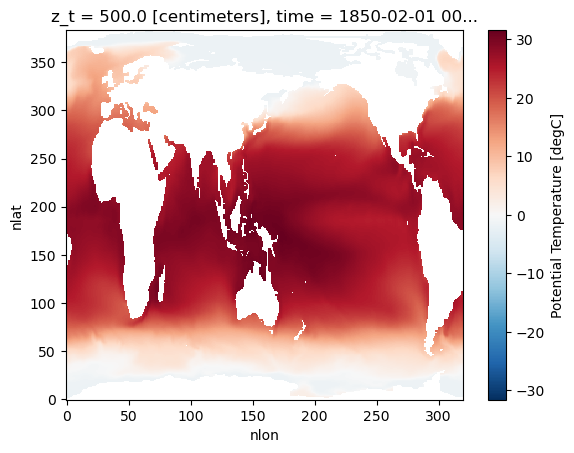

In [27]:
# field on original grid
field.plot()

In [28]:
replacement_value = 0

# Replace non-finite values and masked values
ds_temp['TLAT'] = xr.where(
    np.logical_or(np.isnan(ds_temp['TLAT']), np.isinf(ds_temp['TLAT']) | np.ma.getmask(ds_temp['TLAT'])),
    replacement_value,
    ds_temp['TLAT']
)

ds_temp['TLONG'] = xr.where(
    np.logical_or(np.isnan(ds_temp['TLONG']), np.isinf(ds_temp['TLONG']) | np.ma.getmask(ds_temp['TLONG'])),
    replacement_value,
    ds_temp['TLONG']
)

Text(0.5, 1.0, 'GetCreative')

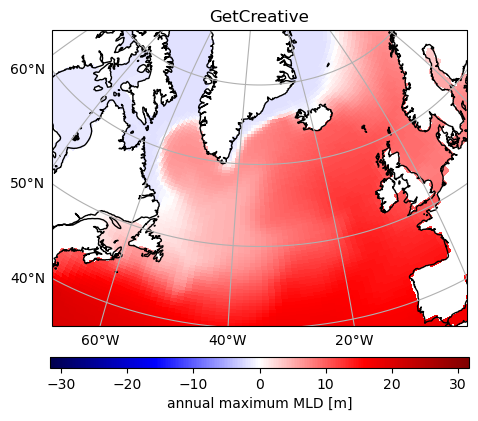

In [30]:
lon_slice = slice('290', '340')
lat_slice = slice('45', '60')
cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, 'aspect':40, 'label':'annual maximum MLD [m]', 'pad': 0.08}

plotting_data = ds_temp.TEMP.isel(z_t=0)

plt.figure(figsize=(9,5));
ax = plt.axes(projection=ccrs.Orthographic(central_latitude=50, central_longitude=-35))
ax.set_extent([-70,0, 40, 75], crs=ccrs.PlateCarree())  ### used in Thesis

pc = plotting_data.plot.pcolormesh(ax=ax, 
                                    transform=ccrs.PlateCarree(),
                                    x='TLONG', 
                                    y='TLAT',
                                    cbar_kwargs=cbar_kwargs,
                                    cmap='seismic'
                                    )

gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False

ax.add_feature(cfeature.COASTLINE, linestyle='-');
plt.title("GetCreative")

## How do I get WGS 84 (ESPG 4326) latitudes in my latitudinal transects?

In [24]:
field = ds_temp.TEMP.isel(nlon=0)

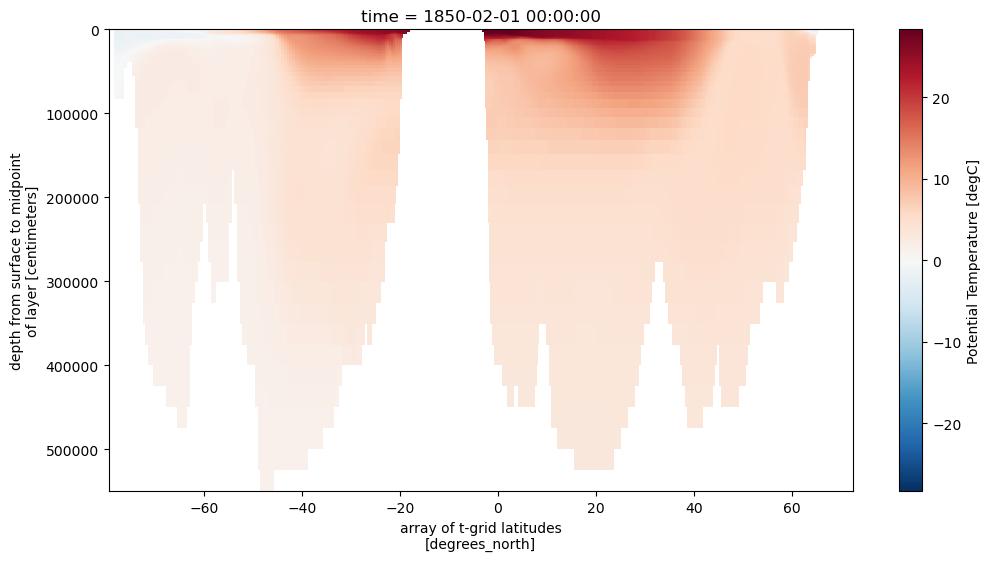

In [25]:
# plot with xarray
plt.figure(figsize=(12, 6))
field.plot.pcolormesh(x='TLAT',y='z_t',yincrease=False)
plt.show()

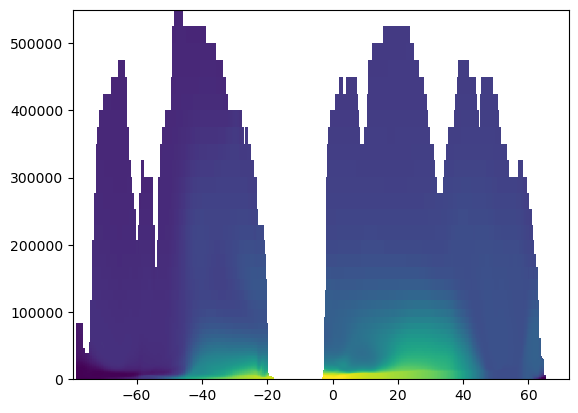

In [27]:
plt.pcolormesh(ds_temp.TLAT.isel(nlon=0), ds_temp.z_t, ds_temp.TEMP.isel(nlon=0))

## How to plot vertical streamfunctions?

In [18]:
moc_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/moc/moc_1001.001.nc'
ds_moc = xr.open_dataset(moc_file).isel(time=0, transport_reg=1, moc_comp=0)

In [19]:
field = ds_moc.MOC

In [20]:
field

<xarray.DataArray 'MOC' (moc_z: 61, lat_aux_grid: 395)>
[24095 values with dtype=float32]
Coordinates:
  * lat_aux_grid  (lat_aux_grid) float32 -79.49 -78.95 -78.42 ... 89.47 90.0
  * moc_z         (moc_z) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05 5.5e+05
    time          object 1850-02-01 00:00:00
Attributes:
    long_name:     Meridional Overturning Circulation
    units:         Sverdrups
    coordinates:   lat_aux_grid moc_z moc_components transport_region time
    cell_methods:  time: mean

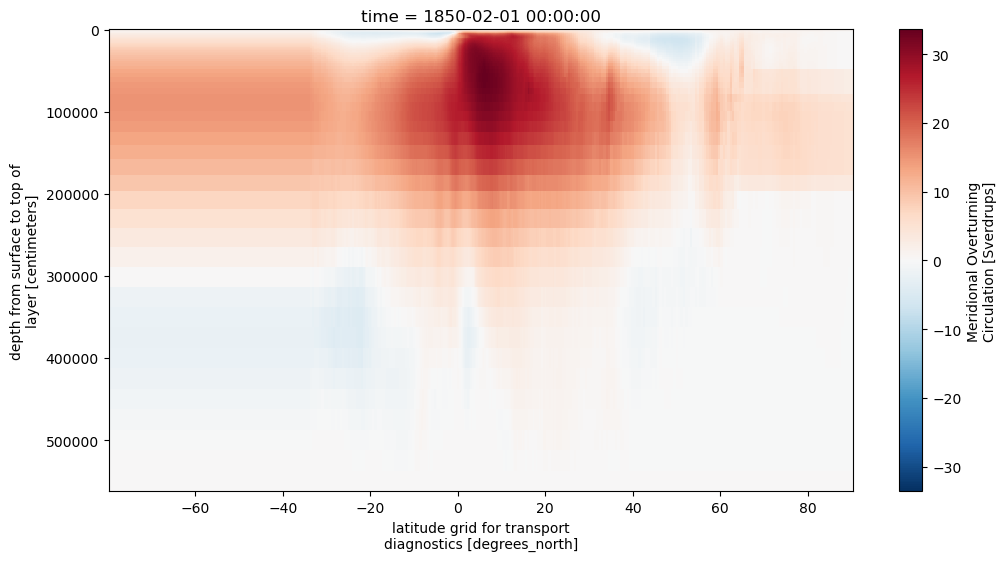

In [21]:

# plot with xarray
plt.figure(figsize=(12, 6))
field.plot.pcolormesh(x='lat_aux_grid',y='moc_z',yincrease=False)
plt.show()

# <span style="color:red"> Possible approaches </span>

## André's approach 

In [18]:
temp_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/temp_1231.001.nc'
KE = xr.open_dataset(temp_file, decode_times=False).TEMP.isel(z_t=0, time=0).squeeze()  # open with xarray, but you can plot any 2D array, e.g. an numpy array you load differently
SST = xr.open_dataset(temp_file, decode_times=False).TEMP.isel(z_t=0, time=0).squeeze()  # squeeze removes time dimension which cartopy sees as a third dimension
MASK = xr.open_dataset(temp_file, decode_times=False).REGION_MASK

In [ ]:
# figure with two subplots
f = plt.figure(figsize=(12,5))
# orthographic projection of kinetic energy
ax = f.add_axes([.02,.05,.4,.9], projection=ccrs.Orthographic(central_longitude=-30, central_latitude=20))  # this projection sets the figure projection
ax.set_title('Orthographic projection')
im = ax.pcolormesh(KE.TLONG, KE.TLAT, np.log(KE).where(MASK>0),  # MASK is usually necessary for the high resolution, otherwise you coudl get plotting artifacts
                   transform=ccrs.PlateCarree(), cmap='cmo.solar')  # this transformation just says lats/lons are in degrees
plt.colorbar(im, ax=ax, orientation='horizontal', extend='both', label=r'log(KE) log[cm$^2$ s$^{-1}$]')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)
gl.ylocator = matplotlib.ticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
ax.add_feature(cartopy.feature.LAND, zorder=2, edgecolor='black')

# platecaree projection of SST
ax = f.add_axes([.45,.05,.53,.9], projection=ccrs.PlateCarree(central_longitude=180))
ax.set_title('Plate Carrée projection')
im = ax.pcolormesh(SST.TLONG, SST.TLAT, SST.where(MASK>0),
                   transform=ccrs.PlateCarree(), cmap='cmo.thermal')
plt.colorbar(im, ax=ax, orientation='horizontal', extend='both', label=r'SST [$^\circ\!$C]')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)
gl.ylocator = matplotlib.ticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
ax.add_feature(cartopy.feature.LAND, zorder=2, edgecolor='black')
ax.add_feature(cartopy.feature.RIVERS, zorder=3, edgecolor='blue')

In [ ]:
# Check for non-finite values in KE.TLONG and KE.TLAT
if not np.isfinite(KE.TLONG).all() or not np.isfinite(KE.TLAT).all():
    raise ValueError("Invalid values in KE.TLONG or KE.TLAT.")

# Check for non-finite values in KE.where(MASK>0)
KE_masked = KE.where(MASK > 0)
if not np.isfinite(KE_masked).all():
    raise ValueError("Invalid values in KE.where(MASK>0).")

# Create the plot
f = plt.figure(figsize=(12, 5))
ax = f.add_axes([.02, .05, .4, .9], projection=ccrs.Orthographic(central_longitude=-30, central_latitude=20))
im = ax.pcolormesh(KE.TLONG, KE.TLAT, KE_masked, transform=ccrs.PlateCarree())

# Add colorbar, title, etc.
# (Add additional customization as needed)

plt.show()

## Joas's approach

In [2]:
# import libraries
import cartopy.crs as ccrs # for geographic plotting
import cartopy.feature as cfeature
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import xarray as xr
import os
from IPython.display import Image
import pickle
import glob
from matplotlib import cm
from matplotlib.colors import BoundaryNorm
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import copy
import pop_tools
import dask.array as da
import sys


import scipy.signal as signal


from datetime import date

from distributed import Client


#from misc import get_ij
import warnings, getpass
warnings.filterwarnings("ignore")

import pickle


In [4]:
hmxl_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/hmxl/hmxl_1231.001.nc'
ds_hmxl = xr.open_dataset(hmxl_file).isel(time=0)

In [15]:
replacement_value = 0

# Replace non-finite values and masked values for TLAT
ds_hmxl['TLAT'] = xr.where(
    np.logical_or(np.isnan(ds_hmxl['TLAT']), np.isinf(ds_hmxl['TLAT']) | np.ma.getmask(ds_hmxl['TLAT'])),
    replacement_value,
    ds_hmxl['TLAT']
)

ds_hmxl['TLONG'] = xr.where(
    np.logical_or(np.isnan(ds_hmxl['TLONG']), np.isinf(ds_hmxl['TLONG']) | np.ma.getmask(ds_hmxl['TLONG'])),
    replacement_value,
    ds_hmxl['TLONG']
)

Text(0.5, 1.0, 'GetCreative')

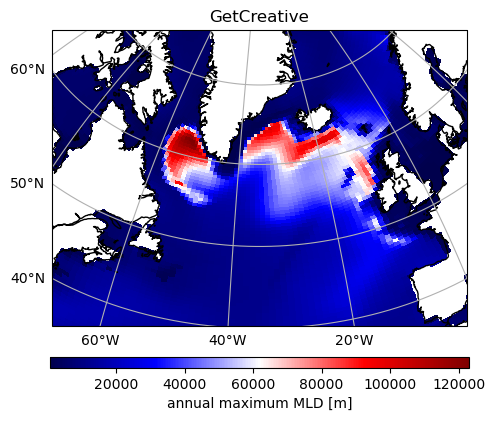

In [18]:
lon_slice = slice('290', '340')
lat_slice = slice('45', '60')
cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, 'aspect':40, 'label':'annual maximum MLD [m]', 'pad': 0.08}

plotting_data = ds_hmxl.HMXL

plt.figure(figsize=(9,5));
ax = plt.axes(projection=ccrs.Orthographic(central_latitude=50, central_longitude=-35))
ax.set_extent([-70,0, 40, 75], crs=ccrs.PlateCarree())  ### used in Thesis



pc = plotting_data.plot.pcolormesh(ax=ax, 
                                    transform=ccrs.PlateCarree(),
                                    x='TLONG', 
                                    y='TLAT',
                                    cbar_kwargs=cbar_kwargs,
                                    cmap='seismic'
                                    )

gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False

ax.add_feature(cfeature.COASTLINE, linestyle='-');
plt.title("GetCreative")